# Introductory applied machine learning (INFR10069) 

# Lab 4: Clustering, PCA, and Evaluation

In this lab we consider unsupervised learning in the form of clustering methods and principal component analysis (PCA), as well as more thorough performance evaluation of classifiers.

All the datasets that you will need for this lab are located within the `datasets` directory (i.e. adjacent to this file).

In [1]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from pandas.api.types import CategoricalDtype
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

/Users/mac/anaconda3/envs/py3iaml/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/mac/anaconda3/envs/py3iaml/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Part 1: Clustering the landsat dataset

We first consider clustering of the Landsat data. For information about the Landsat data you can read [this description](http://www.inf.ed.ac.uk/teaching/courses/dme/html/landsat.html). Since there are 6 classes in the data, it would be interesting to try clustering with k=6 centres...

### ========== Question 1.1 ==========
1. With pandas, read the csv dataset located at './datasets/landsat.csv'
1. Split the data into the features `X` (pandas dataframe), and the labels `y` (easier to make it a numpy array)
1. Give it a once over
    * Get a feel for the size
    * Check it looks ok
    * Understand what the features are
    * Plot the class distribution

*Hint: You might need to use the following class labels*:

In [2]:
# Class Categories run from 1 through 7 inclusive (i.e. they are not 0 indexed!)
class_categories = ['red soil', 'cotton crop', 'grey soil', 'damp grey soil', 'soil with vegetation stubble',
                    'mixture class (all types present)', 'very damp grey soil']
class_labels = [1, 2, 3, 4, 5, 6, 7]

*TIP: Do not assume that all labels are present!*

Number of instances: 4435, number of attributes: 36
          pixel1_1     pixel1_2     pixel1_3     pixel1_4     pixel2_1  \
count  4435.000000  4435.000000  4435.000000  4435.000000  4435.000000   
mean     69.473957    83.855242    99.322886    82.555581    69.208794   
std      13.649635    22.725079    16.672166    18.695450    13.552423   
min      40.000000    27.000000    56.000000    33.000000    40.000000   
25%      60.000000    71.000000    85.000000    70.000000    60.000000   
50%      68.000000    87.000000   101.000000    83.000000    68.000000   
75%      80.000000   103.000000   113.000000    92.000000    80.000000   
max     104.000000   137.000000   140.000000   154.000000   102.000000   

          pixel2_2     pixel2_3     pixel2_4     pixel3_1     pixel3_2  \
count  4435.000000  4435.000000  4435.000000  4435.000000  4435.000000   
mean     83.499436    99.174521    82.480496    68.963472    83.131003   
std      22.811809    16.627583    18.714272    13.497858  

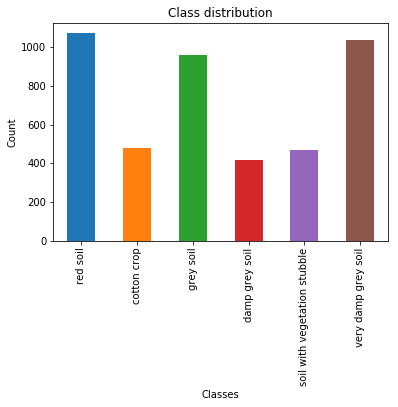

,count,mean,std,min,25%,50%,75%,max
band,,,,,,,,
1,39915.0,69.128022,13.556420,39.0,60.0,68.0,80.0,104.0
2,39915.0,83.450482,22.790675,27.0,71.0,85.0,103.0,137.0
3,39915.0,99.188876,16.689490,50.0,85.0,101.0,113.0,145.0
4,39915.0,82.566429,18.836535,29.0,69.0,81.0,92.0,157.0


In [4]:
# Student needs to provide code similar to below
# (1) - Read Data
data_path = os.path.join(os.getcwd(), '../Labs/datasets', 'landsat.csv')
landsat = pd.read_csv(data_path, delimiter = ',')
# (2) - Split
X = landsat.drop('class', axis=1)
y = landsat['class'].values
# (3) - Exploratory Analysis
print('Number of instances: {}, number of attributes: {}'.format(X.shape[0], X.shape[1]))
print(landsat.describe())
# Notice that 'class' is categorical (not numeric) and count
fig, ax = plt.subplots()
landsat['class'].astype('category').value_counts(sort=False).plot(kind='bar', ax=ax) # Create Counts
labels = [int(ticklabel.get_text()) for ticklabel in ax.get_xticklabels()] # Get the current labels
ax.set_xticklabels([class_categories[l-1] for l in labels])
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class distribution')
plt.show()
# Advanced (not expecting you to have done this) - describe pixel values by band
landsat_melt = pd.melt(landsat, id_vars=['class'], var_name='pixel_label')
landsat_melt['band'] = landsat_melt['pixel_label'].str[-1]
landsat_melt.groupby('band')['value'].describe()


### ========== Question 1.2 ==========

*TIP - don't get stuck on this, move on after 10 mins or so (it's not critical)*

Plot a few datapoints. You'll need to understand and reshape the datapoints to do this. *Hint: try reading the [detailed description](http://www.inf.ed.ac.uk/teaching/courses/dme/html/satdoc.txt), it'll take you 2 minutes...`plt.imshow()` or `sns.heatmap()` (with an `ax.invert_yaxis()`) may also be handy ;)*

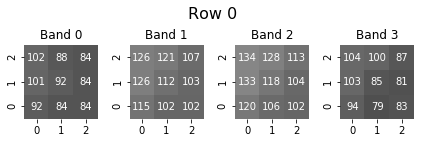

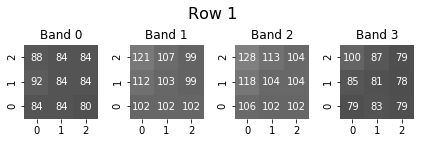

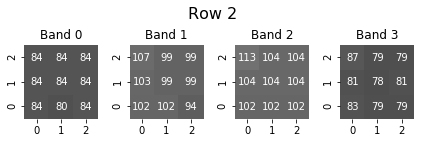

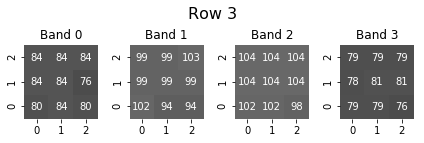

In [5]:
# Student needs to provide code similar to below
def get_images(row, bands=None):    
    # Get each of the 4 3x3 images contained in the row
    # Pixels are labeled 1 to 9 from topleft to bottom right
    # They are measured at 4 spectral bands
    #
    # row - a numpy array
    if bands is None:
        img = [[]] * 4
        for ii in range(4):
            img[ii] = row[[4*p + ii for p in range(9)]].values.reshape((3,3)).astype(int)
    elif isinstance(bands, int):
        img = row[[4*p + bands for p in range(9)]].values.reshape((3,3)).astype(int)
    elif isinstance(bands, list):
        img = [[]] * len(bands)
        for ii, band in enumerate(bands):
            img[ii] = row[[4*p + band for p in range(9)]].values.reshape((3,3)).astype(int)
    return img
        
for ii in range(4):
    fig, ax = plt.subplots(1,4)
    plt.suptitle('Row {}'.format(ii), fontsize=16)
    for jj, img in enumerate(get_images(landsat.iloc[ii,:])):
        ax[jj] = sns.heatmap(img, annot=True, fmt="d", ax=ax[jj], vmin=0, vmax=255, 
                    cbar=False, square=True, cmap=plt.cm.gray)
        ax[jj].invert_yaxis()
        ax[jj].set_title('Band {}'.format(jj))
    plt.tight_layout()
    plt.subplots_adjust(top=1.4)


### ========== Question 1.3 ==========

Read [this demonstration of k-means clustering assumptions](http://scikit-learn.org/0.19/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py) from the sklearn documentation. Get a feel for how to create and fit a k-means object and what the different arguments do.

Initialise a [k-means clustering](http://scikit-learn.org/0.19/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) object with 6 clusters, and one other parameter that ensures you can reproduce your results (other arguments kept as default). Call the object `kmeans`. Use the `fit()` method to fit to the training data (`X` - the features of `landsat` created above)

**Be careful to fit `X` - only the features - not the class labels! And Remember to set the `random_state=1000` so that you can reproduce results!**

In [6]:
# Student needs to provide code similar to below
kmeans = KMeans(n_clusters=6, random_state=1000)  
kmeans.fit(X)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1000, tol=0.0001, verbose=0)

### ========== Question 1.4 ==========

The sklearn documentation gives a great introduction to k-means [here](http://scikit-learn.org/0.19/modules/clustering.html#k-means). It describes what the algorithm is trying to minimise - the squared difference between datapoints and their closest cluster centre - a.k.a. the **inertia**. Lower inertia implies a better fit.

So, how well did that work? Are the classes well separated and form 6 nice clusters? Since we have the true class labels in this case, we can use the [adjusted rand index](http://scikit-learn.org/0.19/modules/clustering.html#clustering-performance-evaluation) metric. Understand what it is and roughly how it is calculated (try the [mathematical formulation on sklearn](http://scikit-learn.org/0.19/modules/clustering.html#mathematical-formulation) or [on wikipedia](https://en.wikipedia.org/wiki/Rand_index)).

Print the `inertia` and the `adjusted_rand_score` of the kmeans object. The inertia is contained within the `kmeans` object you just fitted as a property. You need to use `y` and the cluster labels (another property of the `kmeans` object you just made), and are welcome to use the sklearn metrics function [adjusted_rand_score](http://scikit-learn.org/0.19/modules/generated/sklearn.metrics.adjusted_rand_score.html).

In [7]:
# Student needs to provide code similar to below
print(kmeans.inertia_, adjusted_rand_score(y, kmeans.labels_))


11321556.158835351 0.5347867858726397


### ========== Question 1.5 ==========

Let's have a look at the counts of the labels within each cluster. If the clustering has worked well, and the labels are inticative of genuine difference in the data, we should expect each cluster to have one dominant label.

Use `sns.countplot` on `kmeans.labels_` with a hue of `y` to get a plot that counts the number of instances within each cluster, and breaks them down by the class labels.

Below the plot, comment on:
1. How successful the clustering has been at separating data with different labels
1. Focussing on clusters, which are the best?
1. Focussing on labels, which are well identified by the clustering?
1. Which labels are the hardest to determine by the data point cluster assignment?

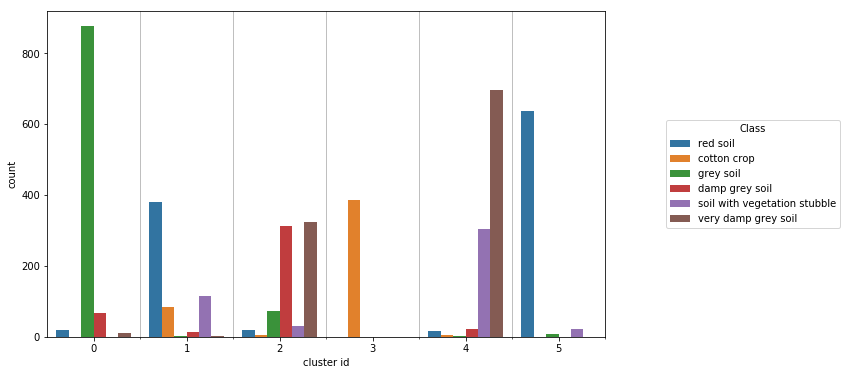

In [8]:
# Student needs to provide code similar to below
# Plot
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x=kmeans.labels_, hue=y, ax=ax)
ax.legend(labels=['red soil','cotton crop','grey soil', 'damp grey soil', 
                  'soil with vegetation stubble', 'very damp grey soil'], #  mixture class does not appear
          loc='center left', bbox_to_anchor=[1.1, 0.5], title='Class')
plt.gca().set_xticks([i + 0.5 for i in range(6)], minor=True)
plt.grid(True, which='minor')
plt.xlabel('cluster id')
plt.show()


***Student needs to answer similar to below:***

1. How successful the clustering has been at separating data with different labels
    * Not so much. There are 3 clusters that contain one main type of datapoint: in our case, these were cluster 2 (grey soil), cluster 4 (cotton crop) and cluster 5 (red soil). In your case the label identities may be different depending on your `random_state`.
1. Focussing on clusters, which are the best?
    * If a datapoint in the training set is in the majority label 4 cluster, you can be certain it is cotton crop. Clusters 5 and 2 are similarly good but not quite as pure
1. Focussing on labels, which are well identified by the clustering?
    * Grey soil data seems well separated in general - most of the datapoints with this label are in one cluster. It's important to note that, though cluster 4 contains only cotton crop datapoints, there are cotton crop data in other clusters. From this we can say that it appears **cotton crop** is mixed up with **red soil** and **soil with vegetation stubble**.
1. Which labels are the hardest to determine by the data point cluster assignment?
    * **damp grey soil** is confused with about 1/3 of **very damp grey soil** data...this doesn't seem particularly surpising. This label (very damp grey soil) is often confused with **soil with vegetation stubble**.
    


## Part 2: Dimensionality reduction

The landsat data is 36 dimensional, so we cannot visualise it, with respect to class, on a nice two dimensional plot. Additionally, as dimensionality increases, euclidean distance [becomes less meaningful](https://en.wikipedia.org/wiki/Curse_of_dimensionality#Distance_functions)...

Perhaps if we found a lower dimensional subspace the data lies upon, we could more easily distinguish the datapoints...

### ========== Question 2.1 ==========

Have a look at the [PCA example](http://scikit-learn.org/0.19/auto_examples/decomposition/plot_pca_iris.html) in the sklearn documentation. For more information about PCA and decomposition in general check out the sklearn [user guide on decomposition](http://scikit-learn.org/0.19/modules/decomposition.html#pca).

We are going to project the data down to 2 dimensions and visualise it using PCA. 

1. Create `pca`, an instance of an [sklearn PCA object](http://scikit-learn.org/0.19/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA), setting n_components to 2. 
1. Create `X_2d` by using the pca method `fit_transform()` and supplying the features `X` to fit and transform to 2d.

In [9]:
# Student needs to provide code similar to below
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)


### ========== Question 2.2 ==========

Let's visualise the data! Use a scatterplot and colour the datapoints by their class. You'll find [this example](http://scikit-learn.org/0.19/auto_examples/decomposition/plot_pca_vs_lda.html) very helpful to adapt. 

Below the plot, comment on whether the data looks more or less seperable now. Do the data look like they will be confused by a k-means clustering in the same way now?

**Extension**: Unless the data is somehow magically perfectly seperable, you may want to try and describe the space a little better than a scatterplot (bacause points are plotted on top of one another). Try and make a plot that clarifies the location of the classes. *Hint: We're actually interested in where the **density** is.*

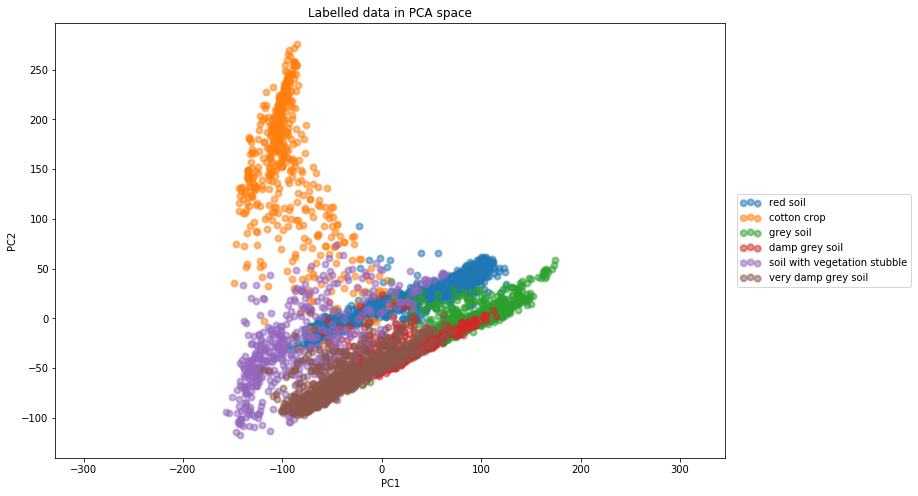

/Users/mac/anaconda3/envs/py3iaml/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


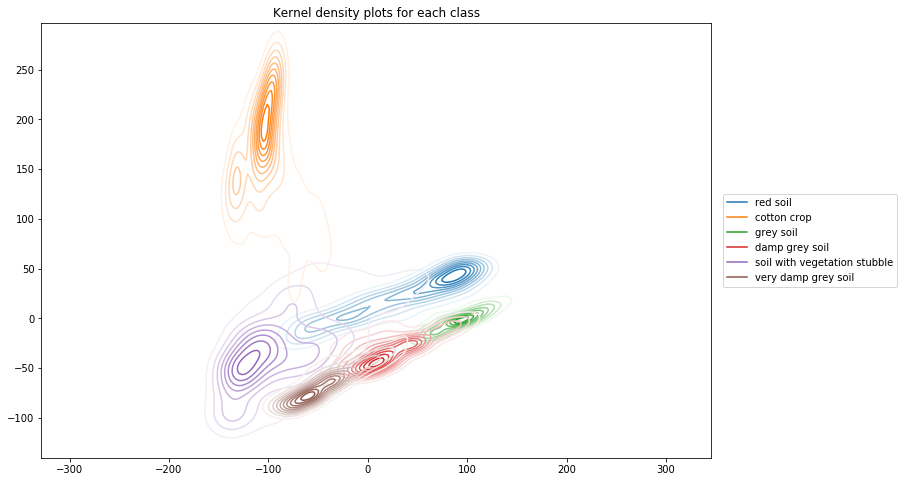

In [10]:
# Student needs to provide code similar to below
# We will need this...
sub_labels = [l for l in class_labels if l != 6]
sub_cats = [class_categories[label-1] for label in sub_labels]

# --- Basic Plot --- #
plt.figure(figsize=(12,8))
for label, cat in zip(sub_labels, sub_cats):
    plt.scatter(X_2d[y == label, 0], X_2d[y == label, 1], alpha=.5, lw=2, label=cat)
plt.axis('equal')
plt.legend(loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5])
plt.title('Labelled data in PCA space')
plt.xlabel('PC1')
plt.ylabel('PC2')
top_plot = plt.gca()
plt.show()

# --- Extension --- #
fig, ax = plt.subplots(figsize=(12,8))
colours = matplotlib.rcParams['axes.prop_cycle'].by_key()['color'] # Keep Track of colours to maintain consistency
for ii, label in enumerate(sub_labels):
    g = sns.kdeplot(X_2d[y == label, 0], X_2d[y == label, 1], ax=ax, n_levels=10, 
                    cmap=sns.light_palette(colours[ii], as_cmap=True))
ax.set_xlim(top_plot.get_xlim())
ax.set_ylim(top_plot.get_ylim())
patches = [mlines.Line2D([], [], color=colours[ii], label=cat) for ii, cat in enumerate(sub_cats)]
plt.legend(patches, sub_cats,  loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5])
plt.title('Kernel density plots for each class')
plt.show()



*Your answer goes here*

Without performing a clustering, it's hard to say whether the data is more or less seperable. However, we can see 6 definite clusters with some overlap in the top plot, but it's not all that clear. The kernel density plot allows us to see better where the density lies. These clusters are not spherical and there is overlap, so k-means will always fail. See in particular the 'red soil' data points vs. the 'soil with vegetation stubble points. As expected, we see the 'cotton crop' data points are very distinct from the rest. 

### ========== Question 2.3 ==========

Let's find out whether it's easier to model the transformed data. Fit k-means to the transformed data and report the inertia and the adjusted rand index. Below, comment on whether it is better or worse.

In [11]:
# Student needs to provide code similar to below
kmeans_pca = KMeans(n_clusters=6, random_state=1337)  
kmeans_pca.fit(X_2d)
kmeans_pca.inertia_, adjusted_rand_score(y, kmeans_pca.labels_)


(4807157.634189873, 0.3250118849551876)

***Student needs to answer similar to below:***

The fit is not as good as before, the adjusted rand index is lower. Note that we cannot compare the inertia with before, because the dimensionality of the spaces is not the same, and hence distances are not defined in the same space!



### ========== Question 2.4 ==========

The blobs in the 2 dimensional plot do look quite gaussian...try another classifier on the 2d data and see if it can perform better. What about using 3 principal component? 

Maybe there are subclasses within each class? Maybe increasing the number of clusters will increase your `adjusted_rand_score`.

Use the adjusted rand score for fair comparison. Why do you think it works better or worse? Discuss with your colleagues and lab tutors why you think you got better/worse/the same results.

=========== Number of Clusters ===========

k-means with 1 clusters on 2D PCA:
ARI: 0.0, Inertia: 45914430.809465334


k-means with 3 clusters on 2D PCA:
ARI: 0.3107272058667739, Inertia: 10082233.48917355


k-means with 5 clusters on 2D PCA:
ARI: 0.3681635607136305, Inertia: 5780212.164471408


k-means with 7 clusters on 2D PCA:
ARI: 0.37923464544197016, Inertia: 4163708.32010919


k-means with 9 clusters on 2D PCA:
ARI: 0.42956450996219425, Inertia: 3075391.2192643415


k-means with 11 clusters on 2D PCA:
ARI: 0.4066007189666339, Inertia: 2341991.0141074825


k-means with 13 clusters on 2D PCA:
ARI: 0.38741201241162476, Inertia: 1855674.2172332131


k-means with 15 clusters on 2D PCA:
ARI: 0.3525142537453227, Inertia: 1542797.1292129327


k-means with 17 clusters on 2D PCA:
ARI: 0.3281607482002166, Inertia: 1331956.1137908618


k-means with 19 clusters on 2D PCA:
ARI: 0.28772347559892253, Inertia: 1170298.2395570874



======== Number of PCA Components ========

k-means with 6 cluste

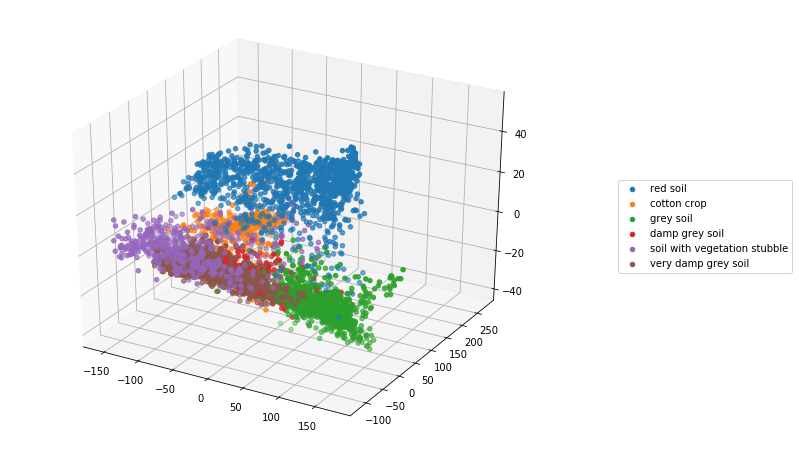

In [12]:
# Student needs to provide code similar to below
# Here are just some examples you could try: Anything goes for this question
# (1) Try different number of cluster for 2D PCA
print('=========== Number of Clusters ===========\n')
for ii in range(1,20,2):
    km = KMeans(n_clusters=ii, random_state=1000)  
    km.fit(X_2d)
    y_pred = km.labels_
    print('k-means with {} clusters on 2D PCA:\nARI: {}, Inertia: {}\n\n'.
          format(ii, adjusted_rand_score(y, y_pred), km.inertia_))

# (2) Try 6 clusters for different PCA Components
print('\n======== Number of PCA Components ========\n')
for ii in range(2, 6):
    X_pca = PCA(n_components = ii).fit_transform(X)
    km = KMeans(n_clusters=6, random_state=1000)  
    km.fit(X_pca)
    y_pred = km.labels_
    print('k-means with 6 clusters on {}D PCA:\nARI: {}, Inertia: {}\n\n'.
          format(ii, adjusted_rand_score(y, y_pred), km.inertia_))
    
# (3) Try Gaussian NB for different PCA Components
print('\n======== Gaussian Naive Bayes PCA ========\n')
for ii in range(2, 6):
    X_pca = PCA(n_components = ii).fit_transform(X)
    gnb = GaussianNB()
    gnb.fit(X_pca, y)
    y_pred = gnb.predict(X_pca)
    print('Gaussian Naive Bayes on {}D PCA:\nARI: {}, Mean Accuracy: {}\n\n'.
          format(ii, adjusted_rand_score(y, y_pred), gnb.score(X_pca, y)))
gnb = GaussianNB()
gnb.fit(X, y)
y_pred = gnb.predict(X)
print('Gaussian Naive Bayes on Full Data\nARI: {}, Mean Accuracy: {}\n\n'.
      format(adjusted_rand_score(y, y_pred), gnb.score(X, y)))


# (4) Try Random Forests
for ii in range(2, 6):
    X_pca = PCA(n_components = ii).fit_transform(X)
    rf = RandomForestClassifier(n_estimators=100, random_state=1337, oob_score=True)
    rf.fit(X_pca, y)
    y_pred = np.argmax(rf.oob_decision_function_, axis=1)
    print('Random Forests on {}D PCA:\nARI: {}, Mean Accuracy: {}\n\n'.
          format(ii, adjusted_rand_score(y, y_pred), rf.oob_score_))
rf = RandomForestClassifier(n_estimators=100, random_state=1000, oob_score=True)
rf.fit(X, y)
y_pred = np.argmax(rf.oob_decision_function_, axis=1)
print('Random Forest on Full Data\nARI: {}, Mean Accuracy: {}\n\n'.
      format(adjusted_rand_score(y, y_pred), rf.oob_score_))

# (5) Finally Draw the distribution of each label in the 3D PCA space
X_3d = PCA(n_components=3).fit(X).transform(X)
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=30, azim=300)
for label, cat in zip(sub_labels, sub_cats):
    idx = y == label
    ax.scatter(X_3d[idx, 0], X_3d[idx, 1], X_3d[idx, 2], label = cat)
plt.legend(loc='center left', bbox_to_anchor=[1.1, .5])
plt.show()
#ENDHIDE

***Student needs to answer similar to below:***

In our solution we find that there seems to be a sweet spot around 9/10 clusters. This provides some evidence that the  classes are multimodal. You can see that in the plots.

Increasing to 3 PCA dimensions provides a big benefit for k-means and Gaussian Naive Bayes. In fact, it's better than using the full data. Using a random forest, we get the best results using the full data - N.B. We are using the Out-of-bag error here (the training error is 0% as discussed before) so we may find that this is overfitting if given a test set.



# Credits

Lab prepared by Lawrence Murray and Chris Williams, November 2008; revised Athina Spiliopoulou Nov 2009; revised Sean Moran Nov 2011; revised Boris Mitrovic Oct 2013; revised and converted python by James Owers and Agamemnon Krasoulis Oct 2016; revised and updated to python 3 by Michael Camilleri